# **Préparations des données images pour la détection d'objets**

## **Plans**

- ### Importer les bibliothèques pour la manipulation de données
- ### Chargement du données
- ### Etudes des valeurs manquantes
- ### Transformation des coordonnées en format YOLO
- ### Diviser les données en ensembles d’entrainement et de validation
- ### Importer les images sélectionnées dans Data Frame depuis un dossier source vers un dossier de destination
- ### Importer les images sélectionnées et construire leurs fichiers d'annotations
- ### Sources 

## **Importer les bibliothèques pour la manipulation de données**

In [1]:
import numpy as np  # bibliothèque pour le calcul scientifique
import pandas as pd  # Pour la manipulation et d'analyse de données
import json  # pour encoder et décoder des données
import matplotlib.pyplot as plt  # bibliothèque de visualisation
import seaborn as sns # pour dessiner des graphiques statistiques attractifs et informatifs
import os  # pour manipuler les fichiers et les répertoires
import shutil  # permet de réaliser des opérations de gestion de fichiers et de répertoires
from shutil import move  # permet de déplacer un fichier ou un répertoire

## **Chargement du données**

In [2]:
def extract_positions(json_str):
    """
    Extrait les positions d'une chaîne JSON et les retourne sous forme de Série.
    """
    if isinstance(json_str, str):
        pos_dict = json.loads(json_str)
        return pd.Series(pos_dict)
    else:
        return pd.Series({"pos1X": None, "pos1Y": None, "pos2X": None, "pos2Y": None})

def filter_and_extract_positions(file_path, columns, usernames):
    """
    Arguments:
    file_path -- le chemin vers le fichier CSV
    columns -- une liste de colonnes à sélectionner dans le DataFrame
    usernames -- une liste de noms d'utilisateur à filtrer dans la colonne 'username'

    Retourne:
    Un DataFrame filtré et enrichi avec les positions extraites.
    """
    # Lire le fichier CSV
    df = pd.read_csv(file_path)
    
    # Sélectionner les colonnes spécifiques
    selected_columns_df = df[columns]
    
    # Créer une expression régulière pour les noms d'utilisateur
    username_pattern = '|'.join(usernames)
    
    # Filtrer les lignes basées sur les noms d'utilisateur
    filtered_df = selected_columns_df[selected_columns_df['username'].str.contains(username_pattern, case=False, na=False)]
    
    # Extraire les positions à partir de la colonne 'value'
    positions_df = filtered_df['value'].apply(extract_positions)
    
    # Concaténer les positions extraites avec le DataFrame filtré
    filtered_df = pd.concat([filtered_df, positions_df], axis=1)
    
    # Supprimer la colonne 'value'
    filtered_df = filtered_df.drop('value', axis=1)
    
    # Supprimer les colonnes 'posX' et 'posY'
    filtered_df = filtered_df.drop(['posX', 'posY'], axis=1, errors='ignore')
    
    return filtered_df

# Exemple d'utilisation
file_path = '/home/cristele/Téléchargements/export_Mission_BathyBot1_20240626.csv'
columns = ['name', 'name_fr', 'username', 'value']
usernames = [] # On peut mettre None ou [] pour ne pas filtrer par username

filtered_and_extracted_data = filter_and_extract_positions(file_path, columns, usernames)

## **Etudes des valeurs manquantes**

/tmp/ipykernel_14863/1662369018.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=missing_percentages.index, y=missing_percentages, palette="viridis")


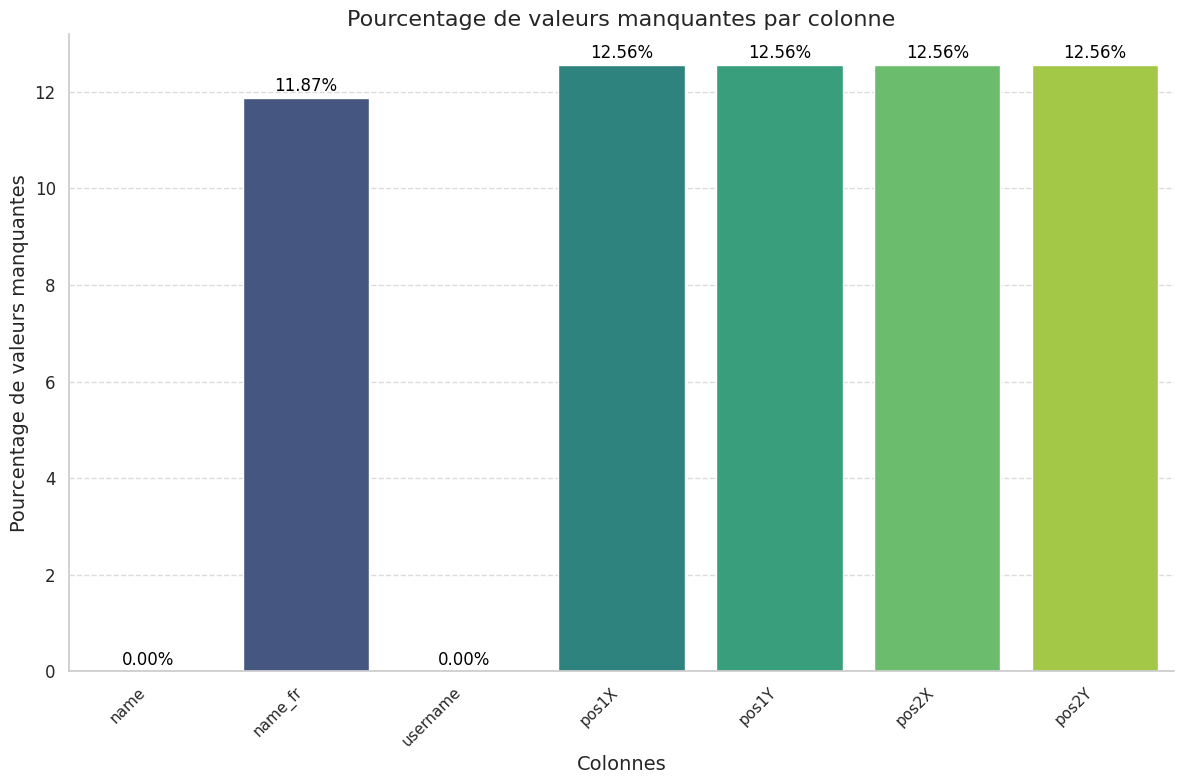

In [3]:
# Calculer le pourcentage de valeurs manquantes pour chaque colonne
missing_percentages = filtered_and_extracted_data.isnull().mean() * 100

# Configurer le style de seaborn
sns.set(style="whitegrid")

# Créer une nouvelle figure
plt.figure(figsize=(12, 8))

# Créer un graphique avec seaborn
ax = sns.barplot(x=missing_percentages.index, y=missing_percentages, palette="viridis")

# Ajouter des annotations pour chaque barre
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Ajouter des titres et des labels
plt.title('Pourcentage de valeurs manquantes par colonne', fontsize=16)
plt.xlabel('Colonnes', fontsize=14)
plt.ylabel('Pourcentage de valeurs manquantes', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Supprimer les bordures supérieures et droites
sns.despine()

# Ajuster la disposition
plt.tight_layout()

# Afficher le graphique
plt.show()

## **Transformation des coordonnées en format YOLO**

In [4]:
def process_data(df):
    """
    Traite les données pour renommer les colonnes, réorganiser les coordonnées, et calculer
    les nouvelles colonnes 'center_x', 'center_y', 'w', et 'h'.

    Arguments:
    df -- le DataFrame à traiter

    Retourne:
    Un DataFrame traité.
    """
    # Supprimer les lignes contenant des valeurs manquantes
    df = df.dropna()
    
    # Renommer les colonnes
    df = df.rename(columns={
        "pos1X": "xmin",
        "pos1Y": "ymin",
        "pos2X": "xmax",
        "pos2Y": "ymax"
    })

    # Réorganiser les coordonnées pour s'assurer que xmin < xmax et ymin < ymax
    def order_coordinates(row):
        if row['xmin'] > row['xmax']:
            row['xmin'], row['xmax'] = row['xmax'], row['xmin']
        if row['ymin'] > row['ymax']:
            row['ymin'], row['ymax'] = row['ymax'], row['ymin']
        return row

    df = df.apply(order_coordinates, axis=1)

    # Convertir les colonnes en entiers
    cols = ['xmin', 'xmax', 'ymin', 'ymax']
    df[cols] = df[cols].astype(int)

    # Ajouter les dimensions de l'image
    df['width'] = 1920
    df['height'] = 1080

    # Calculer les nouvelles colonnes 'center_x', 'center_y', 'w', et 'h'
    df['center_x'] = ((df['xmax'] + df['xmin']) / 2) / df['width']
    df['center_y'] = ((df['ymax'] + df['ymin']) / 2) / df['height']
    df['w'] = (df['xmax'] - df['xmin']) / df['width']
    df['h'] = (df['ymax'] - df['ymin']) / df['height']

    # Filtrer les lignes pour s'assurer que les valeurs sont entre 0 et 1
    df = df[(df['center_x'] <= 1) & (df['center_y'] <= 1) & (df['w'] <= 1) & (df['h'] <= 1)]

    # Réinitialiser l'index
    df = df.reset_index(drop=True)
    
    return df

# Traiter les données
processed_data = process_data(filtered_and_extracted_data)

In [5]:
processed_data

,name,name_fr,username,xmin,ymin,xmax,ymax,width,height,center_x,center_y,w,h
0,vlcsnap-2023-04-21-10h15m37s208.jpg,Posidonie,juliabraga,947,390,1309,636,1920,1080,0.587500,0.475000,0.188542,0.227778
1,vlcsnap-2023-05-12-22h26m35s675.jpg,Concombre de mer,juliabraga,907,881,966,930,1920,1080,0.487760,0.838426,0.030729,0.045370
2,vlcsnap-2023-11-09-16h12m10s638.jpg,Crinoide,juliabraga,1017,924,1383,1161,1920,1080,0.625000,0.965278,0.190625,0.219444
3,XNP-6040H 20230422 011753.jpg,Amphipode,juliabraga,1173,1000,1289,1075,1920,1080,0.641146,0.960648,0.060417,0.069444
4,XNP-6040H 20230422 011753.jpg,Amphipode,juliabraga,797,770,830,805,1920,1080,0.423698,0.729167,0.017188,0.032407
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6568,frame_20240430152342878927.jpg,Poisson 4,Marie69,1151,341,1264,386,1920,1080,0.628906,0.336574,0.058854,0.041667
6569,frame_20240430152949855510.jpg,Poisson 3,Marie69,1240,232,1683,395,1920,1080,0.761198,0.290278,0.230729,0.150926
6570,frame_20240430152949855510.jpg,Posidonie,Marie69,27,203,232,253,1920,1080,0.067448,0.211111,0.106771,0.046296
6571,frame_20240430152948946205.jpg,Poisson 3,Marie69,1177,235,1610,362,1920,1080,0.725781,0.276389,0.225521,0.117593


## **Diviser les données en ensembles d’entrainement et de validation**

In [19]:
def split_and_label_encode(df, label_column, frac=0.8):
    """
    Arguments:
    df -- le DataFrame à diviser et encoder
    label_column -- la colonne contenant les labels à encoder
    frac -- la fraction des données à utiliser pour l'ensemble d'entraînement (le reste sera utilisé pour l'ensemble de test)

    Retourne:
    Deux DataFrames : train_df et test_df, avec une colonne 'id' contenant les labels encodés.
    """
    # Extraire les noms uniques
    images = df['name'].unique()

    # Créer un DataFrame avec les noms uniques
    img_df = pd.DataFrame(images, columns=['name'])

    # Diviser les données en ensembles d'entraînement et de test
    img_train = tuple(img_df.sample(frac=frac)['name'])
    img_test = tuple(img_df.query(f'name not in {img_train}')['name'])

    # Filtrer le DataFrame pour créer les ensembles d'entraînement et de test
    train_df = df.query(f'name in {img_train}')
    test_df = df.query(f'name in {img_test}')

    # Créer un dictionnaire d'encodage pour les labels
    unique_labels = df[label_column].unique()
    label_dict = {label: idx + 1 for idx, label in enumerate(unique_labels)}

    # Appliquer l'encodage des labels
    train_df['id'] = train_df[label_column].apply(lambda x: label_dict[x])
    test_df['id'] = test_df[label_column].apply(lambda x: label_dict[x])

    return train_df, test_df, label_dict

train_df, test_df, label_dict = split_and_label_encode(processed_data, 'name_fr')

/tmp/ipykernel_35083/431277013.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['id'] = train_df[label_column].apply(lambda x: label_dict[x])
/tmp/ipykernel_35083/431277013.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['id'] = test_df[label_column].apply(lambda x: label_dict[x])


## **Importer les images sélectionnées dans Data Frame depuis un dossier source vers un dossier de destination**

In [20]:
def copy_images(df, source_folder, destination_folder):
    """
    Copie les images listées dans le DataFrame 'df' du dossier source vers le dossier de destination.

    Arguments:
    df -- le DataFrame contenant les noms des images à copier
    source_folder -- le dossier source contenant toutes les images
    destination_folder -- le dossier de destination où les images sélectionnées seront copiées
    """
    image_names = df['name'].tolist()

    # Créer le dossier de destination s'il n'existe pas déjà
    os.makedirs(destination_folder, exist_ok=True)

    # Copier les images sélectionnées dans le dossier de destination
    copied_images = []
    for root, dirs, files in os.walk(source_folder):
        for file in files:
            if file in image_names:
                source_path = os.path.join(root, file)
                destination_path = os.path.join(destination_folder, file)
                if os.path.exists(source_path):
                    shutil.copy(source_path, destination_path)
                    copied_images.append(file)
                    print(f'Image {file} copiée dans {destination_folder}')
                else:
                    print(f'Image {file} non trouvée dans {source_folder}')

    # Vérifier le nombre d'images sélectionnées et copiées
    selected_images_count = len(image_names)
    copied_images_count = len(copied_images)

    print(f'Nombre d\'images sélectionnées : {selected_images_count}')
    print(f'Nombre d\'images copiées : {copied_images_count}')

    if selected_images_count == copied_images_count:
        print('Toutes les images sélectionnées ont été copiées avec succès.')
    else:
        print('Le nombre d\'images copiées ne correspond pas au nombre d\'images sélectionnées.')

# Dossier source contenant toutes les images
source_folder = '/home/cristele/Stage_Computer_Vision/Images'

# Dossiers destination pour train et test
train_destination_folder = '/home/cristele/Stage_Computer_Vision/Train_Images'
test_destination_folder = '/home/cristele/Stage_Computer_Vision/Test_Images'

# Copier les images pour train_df
copy_images(train_df, source_folder, train_destination_folder)

# Copier les images pour test_df
copy_images(test_df, source_folder, test_destination_folder)


Image frame_20240430152545713240.jpg copiée dans /home/cristele/Stage_Computer_Vision/Train_Images
Image frame_20240430152619472703.jpg copiée dans /home/cristele/Stage_Computer_Vision/Train_Images
Image frame_20240430152459784944.jpg copiée dans /home/cristele/Stage_Computer_Vision/Train_Images
Image frame_20240430152456295284.jpg copiée dans /home/cristele/Stage_Computer_Vision/Train_Images
Image frame_20240430152357187175.jpg copiée dans /home/cristele/Stage_Computer_Vision/Train_Images
Image frame_20240430152852596739.jpg copiée dans /home/cristele/Stage_Computer_Vision/Train_Images
Image frame_20240430152911562410.jpg copiée dans /home/cristele/Stage_Computer_Vision/Train_Images
Image frame_20240430152733498575.jpg copiée dans /home/cristele/Stage_Computer_Vision/Train_Images
Image frame_20240430152433691947.jpg copiée dans /home/cristele/Stage_Computer_Vision/Train_Images
Image frame_20240430152318492486.jpg copiée dans /home/cristele/Stage_Computer_Vision/Train_Images
Image fram

## **Importer les images sélectionnées et construire leurs fichiers d'annotations**

In [21]:
def combine_folders(train_folder, test_folder, target_folder):
    """
    Arguments:
    train_folder -- le dossier contenant les images d'entraînement
    test_folder -- le dossier contenant les images de test
    target_folder -- le dossier cible où toutes les images seront copiées
    """
    os.makedirs(target_folder, exist_ok=True)

    for folder in [train_folder, test_folder]:
        for filename in os.listdir(folder):
            src = os.path.join(folder, filename)
            dst = os.path.join(target_folder, filename)
            shutil.move(src, dst)
            print(f'Déplacé {filename} vers {target_folder}')

# Définir les chemins des dossiers
train_folder = '/home/cristele/Stage_Computer_Vision/Train_Images'
test_folder = '/home/cristele/Stage_Computer_Vision/Test_Images'
combined_folder = '/home/cristele/Stage_Computer_Vision/Data_recu'

# Combiner les dossiers
combine_folders(train_folder, test_folder, combined_folder)

def save_data(filename, folder_path, group_obj):
    """
    Arguments:
    filename -- le nom de l'image à traiter
    folder_path -- le dossier de destination pour l'image
    group_obj -- l'objet groupé contenant les informations de l'image
    """
    src = os.path.join(combined_folder, filename)
    dst = os.path.join(folder_path, filename)
    move(src, dst)

    text_filename = os.path.join(folder_path, os.path.splitext(filename)[0] + '.txt')
    group_obj.get_group(filename).set_index('name').to_csv(text_filename, sep=' ', index=False, header=False)

def process_and_save_data(df, folder_path, combined_folder):
    """
    Arguments:
    df -- le DataFrame contenant les informations sur les images
    folder_path -- le dossier de destination pour les images
    combined_folder -- le dossier contenant toutes les images combinées
    """
    cols = ['name', 'id', 'center_x', 'center_y', 'w', 'h']
    group_obj = df[cols].groupby('name')

    filename_series = pd.Series(group_obj.groups.keys())
    filename_series.apply(save_data, args=(folder_path, group_obj))

# Définir les chemins des dossiers
combined_folder = '/home/cristele/Stage_Computer_Vision/Data_recu'
train_folder = '/home/cristele/Stage_Computer_Vision/Data_recu/Data_Train'
test_folder = '/home/cristele/Stage_Computer_Vision/Data_recu/Data_Test'

# Créer les dossiers de destination pour les images d'entraînement et de test
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Traiter et sauvegarder les données pour les ensembles d'entraînement et de test
process_and_save_data(train_df, train_folder, combined_folder)
process_and_save_data(test_df, test_folder, combined_folder)

Déplacé frame_20240430152545713240.jpg vers /home/cristele/Stage_Computer_Vision/Data_recu
Déplacé frame_20240430152619472703.jpg vers /home/cristele/Stage_Computer_Vision/Data_recu
Déplacé frame_20240430152459784944.jpg vers /home/cristele/Stage_Computer_Vision/Data_recu
Déplacé frame_20240430152456295284.jpg vers /home/cristele/Stage_Computer_Vision/Data_recu
Déplacé frame_20240430152357187175.jpg vers /home/cristele/Stage_Computer_Vision/Data_recu
Déplacé frame_20240430152852596739.jpg vers /home/cristele/Stage_Computer_Vision/Data_recu
Déplacé frame_20240430152911562410.jpg vers /home/cristele/Stage_Computer_Vision/Data_recu
Déplacé frame_20240430152733498575.jpg vers /home/cristele/Stage_Computer_Vision/Data_recu
Déplacé frame_20240430152433691947.jpg vers /home/cristele/Stage_Computer_Vision/Data_recu
Déplacé frame_20240430152318492486.jpg vers /home/cristele/Stage_Computer_Vision/Data_recu
Déplacé frame_20240430152742294157.jpg vers /home/cristele/Stage_Computer_Vision/Data_recu

## **Sources**